<img src='./img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

<hr>

# Sentinel-2 MSI Level 2A - Composite Imagery, Normalized Burn Ratio and Burn Severity

### About

This notebook provides you an introduction to data from the [Sentinel-2 MultiSpectral Instrument (MSI)](https://sentinel.esa.int/web/sentinel/missions/sentinel-2/instrument-payload), which has has 13 spectral bands which provide data for land cover/change classification, atmospheric correction and cloud/snow separation. This notebook demonstrates several ways that Level 2A data from Sentinel-2 can be used, including the creation of composite imagery, calculation of a burn index and burn severity mapping. 

The events featured in this notebook are the wildfires in Gironde, France in July and August 2022. The images show the burn scar in Gironde after the fires were brought under control.

### Basic Facts

> **Spatial resolution**: `10m, 20m and 60m`<br>
> **Spatial coverage**: `Near global` <br>
> **Revisit time**: `5 days at the equator` <br>
> **Data availability**: `since 2015`


### How to access the data

Sentinel-2 Level 2A data can be obtained via the [Copernicus Open Access Hub](https://scihub.copernicus.eu/dhus/#/home) and are disseminated as `.zip archives` when downloaded. You need to register for an account before downloading data.

The data when unzipped, are in "SENTINEL-SAFE format, including image data in JPEG2000 format, quality indicators (e.g. defective pixels mask), auxiliary data and metadata." [Learn more about the data format here.](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/data-formats)

### Module outline
- [1 - Load and browse the Sentinel-2 MSI data](#s2_load)
- [2 - Create natural colour composite](#s2_natural)
- [3 - Create false colour composite](#s2_false)
- [4 - Calculate the Normalized Burn Ratio (NBR) and Differenced NBR images](#s2_nbr)
- [5 - Create the burn severity map](#s2_burnseverity)

#### Load required libraries

In [1]:
import os
import numpy as np
import pandas as pd
import glob as glob

# Python libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
from skimage import exposure
import rasterio
from rasterio import plot
from rasterio.plot import show

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

##### Load helper functions

In [2]:
%run ./functions.ipynb

<hr>

## <a id='s2_load'></a>1. Load and browse the Sentinel-2 MSI data

### [Optional] Unzip the downloaded Sentinel-2 zipped archives

Here are files from visualizing the burn scar after the fire using a false color composite on 20 September 2022.

The first step is to use the zipfile library to unzip and extract the contents of the two zipped archives downloaded. You need to pass in the file paths of the zip file an input to the `.ZipFile()` function as well as `r` which stands for read. This step is optional as we have already unzipped the file for you. This is why the code is commented out.

You also need to pass in the path to the folder where you want to store the unzipped contents to the `.extractall()` function.

In [5]:
import zipfile
with zipfile.ZipFile('../eodata/portugal_fire_workshop/sentinel-2/S2A_MSIL1C_20220920T105741_N0400_R094_T30TXQ_20220920T144224.zip', 'r') as zip_ref:
    zip_ref.extractall('../eodata/portugal_fire_workshop/sentinel-2/')

A SENTINEL-2 product refers to a directory folder that contains a collection of information. Upon unzipping you will see that it includes:

- a `manifest.safe` file which holds the general product information in XML
- a `preview image` in JPEG2000 format
- `GRANULE`: subfolders for measurement datasets including image data (granules/tiles) in GML-JPEG2000 format
- `DATASTRIP`: subfolders for datastrip level information
- `AUX_DATA`: a subfolder with auxiliary data (e.g. International Earth Rotation & Reference Systems (IERS) bulletin)
- `HTML`: HTML previews
- `rep_info`

The image data is contained several levels down within the `GRANULE` folder. A granule or tile is a 100x100 km<sup>2</sup> ortho-image in the UTM/WGS84 projection.

## <a id='s2_natural'></a>2. Create natural colour composite

### Natural colour composite

Natural colour composites assign the red, green and blue channels of image to show the corresponding visible red, visible green and visible blue bands of the satellite data. The recipe for the natural colour composites is as follows: Red-Green-Blue 4-3-2. Band 4, 3 and 2 have a native resolution of 10m. You can define the file path leading to the `R10m` folder and save it as a variable called `burnscar`.

You can use the Python library [rasterio](https://rasterio.readthedocs.io/en/latest/) to open the Sentinel-2 MSI `jp2` format data using the function `rasterio.open()`. You need to pass in the file path containing the name of the file as a parameter.  

You then do this for all the files for the three bands you will use to make the composite.

In [6]:
burnscar = '../eodata/sentinel-2/S2A_MSIL1C_20220920T105741_N0400_R094_T30TXQ_20220920T144224.SAFE/GRANULE/L1C_T30TXQ_A037843_20220920T110122/IMG_DATA/'

band2=rasterio.open(burnscar + "T30TXQ_20220920T105741_B02.jp2")
band3=rasterio.open(burnscar + "T30TXQ_20220920T105741_B03.jp2")
band4=rasterio.open(burnscar + "T30TXQ_20220920T105741_B04.jp2")

Next, you can extract the metadata associated with a single band and update it to have a `count` of 3, as the resulting natural colour composite will have 3 bands at the end.

In [7]:
meta = band2.meta
meta.update({"count": 3})

Define a destination image path where you will write (`w`) the resulting natural colour composite image to as a `tif` file. You can add metadata to the composite image using `**meta`. Finally, you can write the first and only band from `band2`, `band3` and `band4` to the destination image. You can also specify the order of these bands. In the following code block, you designated `band2` as the first band, followed by `band3` and `band4`. 

In [8]:
natural_rgb_path = 'rasterio/natural_S2_RGB.tif'

with rasterio.open(natural_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

Now, you can open the `tif` file that you just created.

In [9]:
img = rasterio.open(natural_rgb_path)

Next, the image can be read in as one numpy array per band and inspect the shape of the overall array.

In [10]:
image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 10980, 10980)

The shape of the array is `(3, 10980, 10980)`. Note that the interpretation of the 3 axes shown in the shape is `(bands, rows, columns)`. This means you have to transpose the array and add index=0 on index position 3.

In [11]:
image = image.transpose(1,2,0)

In a subsequent step, you then scale the values to the range between 0 and 1, clipping the lower and upper 2 percentiles so that a potential contrast decrease caused by outliers is eliminated. This uses the `exposure.rescale_intensity()` function from the [scikit-image](https://scikit-image.org/) library.


In [12]:
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

Finally, you can plot the natural color composite with the matplotlib library.

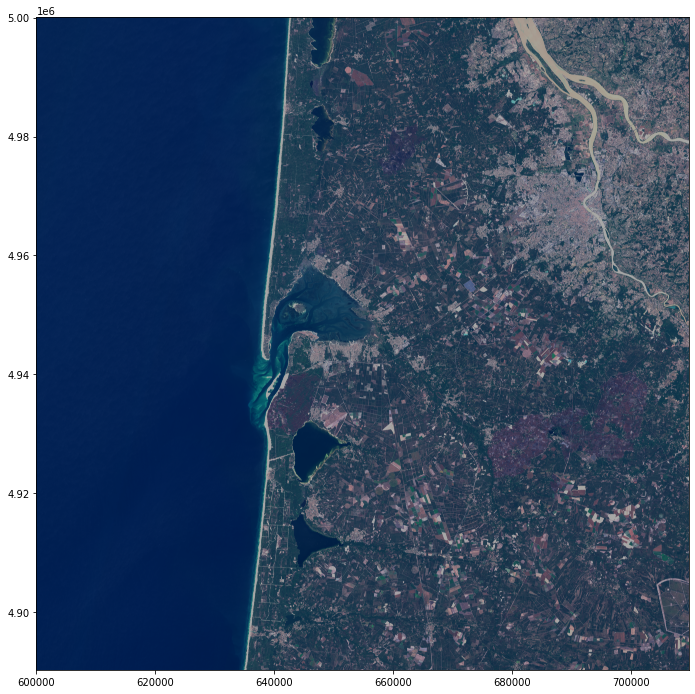

<AxesSubplot:>

In [13]:
# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform)

**Return to the case study:**
- [Monitoring fires with next-generation satellites from MTG and Metop-SG: Gironde, France Wildfires Case Study](./00_gironde_application_case.ipynb#gironde_fig6)

## <a id='s2_false'></a>3. Create false colour composites

### False colour composite

You can use a false colour composite to makes burn scars more easily distinguishable. The recipe for the false colour composite is: `Red-Green-Blue 12-8A-2`. This means that the `red` channel was assigned to `band 12` (shortwave infrared), the `green` channel was assigned to `band 8A` (near-infrared) and the `blue` channel was assigned to `band 2` (the visible blue band). 

You can use the Python library [rasterio](https://rasterio.readthedocs.io/en/latest/) to open the Sentinel-2 MSI `jp2` format data using the function `rasterio.open()`. You need to pass in the file path containing the name of the file as a parameter.  

You then do this for all the files for the three bands you will use to make the composite.

In [14]:
band12=rasterio.open(burnscar + "T30TXQ_20220920T105741_B12.jp2")
band8a=rasterio.open(burnscar + "T30TXQ_20220920T105741_B8A.jp2")
band2=rasterio.open(burnscar + "T30TXQ_20220920T105741_B02.jp2")

Next, you can extract the metadata associated with a single band and update it to have a `count` of 3, as the resulting natural colour composite will have 3 bands at the end.

In [15]:
meta = band2.meta
meta.update({"count": 3})

Define a destination image path where you will write (`w`) the resulting natural colour composite image to as a `tif` file. You can add metadata to the composite image using `**meta`. Finally, you can write the first and only band from `band2`, `band3` and `band4` to the destination image. You can also specify the order of these bands. In the following code block, you designated `band2` as the first band, followed by `band3` and `band4`. 

In [16]:
false_rgb_path = 'rasterio/false_S2_RGB.tif'

with rasterio.open(false_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band8a.read(1),2)
    dest.write(band12.read(1),3)

Now, you can open the `tif` file that you just created.

In [17]:
img = rasterio.open(false_rgb_path)

Next, the image can be read in as one numpy array per band and inspect the shape of the overall array.

In [18]:
image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 10980, 10980)

The shape of the array is `(3, 5490, 5490)`. Note that the interpretation of the 3 axes shown in the shape is `(bands, rows, columns)`. This means you have to transpose the array and add index=0 on index position 3.

In [19]:
image = image.transpose(1,2,0)

In a subsequent step, you then scale the values to the range between 0 and 1, clipping the lower and upper 2 percentiles so that a potential contrast decrease caused by outliers is eliminated. This uses the `exposure.rescale_intensity()` function from the [scikit-image](https://scikit-image.org/) library.


In [ ]:
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

Finally, you can plot the resulting false color composite with the matplotlib library.

In [ ]:
# Define a plot
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform)

**Return to the case study:**
- [Monitoring fires with next-generation satellites from MTG and Metop-SG: Gironde, France Wildfires Case Study](./00_gironde_application_case.ipynb#gironde_fig7)

<hr>

### References
* Copernicus Sentinel data 2022

* Some code in this notebook was adapted from the following sources:
    * origin: https://gis.stackexchange.com/questions/341809/merging-sentinel-2-rgb-bands-with-rasterio
    * copyright: 2020, G.L.
    * license: CC BY-SA 4.0
    * retrieved: 2022-06-28 by Sabrina Szeto

<hr>

<p style="text-align:right;">This project is licensed under the <a href="../LICENSE">GPL-3.0 License</a> and is developed under a Copernicus contract.